# Anggota Tim :
- Ni Made Ayu Aghata Widya Lestari (1201194075)
- Lutfi Muhammad (1201190253)
- Kartika Salsabilla Wulandari (1201194051)
- Meyliza Gusandi (1201174281)

# Setup
Menggunakan module numpy dengan alasan kecepatan dalam pemrosesan list dan juga support vector, selain itu menggunakan module matplotlib untuk membuat visualisasi dari data yang dihasilkan

In [1]:
!pip install --upgrade pip
!pip install numpy
!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
%matplotlib InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")
np.random.seed(42) # fungsi ini supaya nomor random yang di generate tidak selalu berubah ketika di eksesuki (memudahkan debug)


UsageError: unrecognized arguments: = 'svg'


# Membuat Representasi
TSP membutuhkan data kota dan juga jarak antar kota, disini dicoba terlebih dahulu untuk merepresentasikan secara eksplisit kota dan jarak antar kota. Represntasi antara jarak antar kota <sub>_i_</sub> dan <sub>_j_</sub> sehingga _A_<sub>_ij_</sub> menyatakan jarak antara kedua kota.

keterangan : 
_cities_ = kota
_adjacency_mat_ = matriks jarak antar kota

In [3]:
cities = [0, 1, 2, 3, 4]

adjacency_mat = np.asarray(
    [
        [0.00, 28.02, 17.12, 27.46, 46.07],
        [28.02, 0.00, 34.00, 25.55, 25.55],
        [17.12, 34.00, 0.00, 18.03, 57.38],
        [27.46, 25.55, 18.03, 0.00, 51.11],
        [46.07, 25.55, 57.38, 51.11, 0.00],
    ]
)


# Implementasi
Definiskan class yang merepresentasikan Populasi yang didalam nya terdapat informasi spesifik tentang generasi populasi pada class tersebut. Spesifiknya ada informasi tentang :
- _bag_ : representasi dari seluruh populasi (kantong populasi)
- _parents_ : generasi terbaik yang terpilih dari populasi tersebut (atau induk)
- _score_ : menyimpan nilai dari kromosom terbaik dari populasi
- _best_ : menyimpan kromosom terbaik
- _adjacency_mat_ : digunkan untuk menghitung jarak antar kota dalam konteks TSP

In [4]:
class Population():
    def __init__(self, bag, adjacency_mat):
        self.bag = bag
        self.parents = []
        self.score = 0
        self.best = None
        self.adjacency_mat = adjacency_mat

## Fungsi _Generate Random_ Populasi (Inisialisasi Populasi)

In [5]:
def init_population(cities, adjacency_mat, n_population):
        return Population(
            np.asarray([np.random.permutation(cities) for _ in range(n_population)]),
            adjacency_mat
        )

## Melihat isi dari _Generate Dummy_ Populasi
Memastikan fungsi berjalan semestinya

In [6]:
pop = init_population(cities, adjacency_mat, 5)
pop.bag

array([[4, 0, 2, 1, 3],
       [4, 1, 0, 3, 2],
       [2, 0, 4, 3, 1],
       [0, 4, 3, 1, 2],
       [2, 1, 3, 4, 0]])

# Fitness
Sekarang kita membutuhkan beberapa fungsi yang akan menentukan _fitness_ dari sebuah kromosom. Dalam konteks TSP, _fitness_ didefinisikan dalam istilah : semakin pendek jarak total, semakin _fit_ dan semakin unggul kromosom. Semua informasi jarak yang dibutuhkan akan disimpan dalam `self.adjacency_mat`. Kita dapat menghitung jumlah semua jarak antara dua kota yang berdekatan dalam urutan kromosom.

In [7]:
def fitness(self, chromosome):
    return sum(
        [
            self.adjacency_mat[chromosome[i], chromosome[i + 1]]
            for i in range(len(chromosome) - 1)
        ]
    )

Population.fitness = fitness

# Seleksi
Selanjutnya, mengevaluasi populasi. Sederhananya, evaluasi berarti menghitung kesesuaian setiap kromosom dalam populasi total, menentukan siapa yang terbaik, menyimpan informasi skor, dan mengembalikan beberapa vektor probabilitas yang setiap elemennya mewakili probabilitas bahwa elemen ke-i dalam kantong populasi dipilih sebagai _parents_/induk. Kami menerapkan beberapa pra-pemrosesan dasar untuk memastikan bahwa kromosom dengan kinerja terburuk sama sekali tidak memiliki peluang untuk dipilih.

In [8]:
def evaluate(self):
    distances = np.asarray(
        [self.fitness(chromosome) for chromosome in self.bag]
    )
    self.score = np.min(distances)
    self.best = self.bag[distances.tolist().index(self.score)]
    self.parents.append(self.best)
    if False in (distances[0] == distances):
        distances = np.max(distances) - distances
    return distances / np.sum(distances)

Population.evaluate = evaluate

Saat memanggil `pop.evaluate()`, kita mendapatkan vektor probabilitas seperti yang diharapkan.

In [9]:
pop.evaluate()

array([3.13156440e-01, 5.31324857e-01, 1.55518703e-01, 0.00000000e+00,
       2.61854703e-16])

Saat kita memanggil `pop.best`, maka hasil akan mengurutkan kromosom terbaik.

In [10]:
pop.best

array([4, 1, 0, 3, 2])

In [11]:
from IPython.display import Markdown as md
md(f"kita juga dapat melihat skor kromosom terbaik. Dalam hal ini, jarak dikatakan {pop.score}. Perhatikan bahwa semakin rendah skornya, semakin baik, karena skor ini mewakili total jarak yang harus ditempuh seorang penjual untuk mengunjungi semua kota dalam kasus TSP.")

kita juga dapat melihat skor kromosom terbaik. Dalam hal ini, jarak dikatakan 99.06. Perhatikan bahwa semakin rendah skornya, semakin baik, karena skor ini mewakili total jarak yang harus ditempuh seorang penjual untuk mengunjungi semua kota dalam kasus TSP.

In [12]:
pop.score

99.06

# Proses Memilik _Parents_ Untuk Generasi Selanjutnya
Sekarang, kita akan memilih k : jumlah _parents_ untuk menjadi basis generasi berikutnya. Di sini, kami menggunakan model _roulette_ sederhana, di mana kami membandingkan nilai vektor probabilitas dan nomor acak yang diambil dari distribusi seragam. Jika nilai vektor probabilitas lebih tinggi, kromosom yang sesuai ditambahkan ke `self.parents`. Kami mengulangi proses ini sampai kami memiliki k _parents_.

In [13]:
def select(self, k =4):
    fit = self.evaluate()
    while len(self.parents) < k:
        idx = np.random.randint(0, len(fit))
        if fit[idx] > np.random.rand():
            self.parents.append(self.bag[idx])
    self.parents = np.asarray(self.parents)

Population.select = select

In [14]:
pop.select()

Seperti yang diharapkan, kami mendapatkan 4 _parents_ setelah memilih _parents_ melalui `pop.select()`

In [15]:
pop.parents

array([[4, 1, 0, 3, 2],
       [4, 1, 0, 3, 2],
       [2, 0, 4, 3, 1],
       [4, 0, 2, 1, 3]])

# _Swap_
kami menggunakan mutasi swap dan crossover sederhana. Seperti namanya, swap hanya melibatkan pertukaran dua elemen kromosom. Misalnya, jika kita memiliki [a, b, c], kita dapat menukar dua elemen pertama menjadi [b, a, c].

In [16]:
def swap(chromosome):
    a, b = np.random.choice(len(chromosome), 2)
    chromosome[a], chromosome[b] = (
        chromosome[b],
        chromosome[a],
    )
    return chromosome

Masalah dengan mutasi swap, adalah bahwa swapping adalah proses yang sangat mengganggu dalam konteks TSP. Karena setiap kromosom mengkodekan urutan di mana seorang salesman harus mengunjungi setiap kota, bertukar dua kota dapat sangat mempengaruhi skor kebugaran akhir dari kromosom yang bermutasi. Oleh karena itu, kami juga menggunakan bentuk mutasi lain, yang dikenal sebagai crossover.

# _Cross-Over_
kita ambil dua _parents_ kemudian _slice_ sebagian kromosom dari satu _parents_, dan mengisi sisa slot dengan _parents_ lainnya. Saat mengisi sisa slot, kita perlu memastikan bahwa tidak ada duplikat dalam kromosom. Mari kita lihat sebuah contoh. Bayangkan _parents_ satu memiliki `[a, b, c, d, e]` dan yang lainnya memiliki `[b, a, e, c, d]`. Katakanlah kita _slice_ bagian acak dari _parents_ pertama memberi kita `[None, b, c, None, None]`. Kemudian, kami mengisi sisa indeks kosong dengan _parents_ lainnya, dengan memperhatikan urutan kemunculan elemen. Dalam hal ini, kita akan berakhir dengan `[a, b, c, e, d]`.

In [17]:
def crossover(self, p_cross=0.1):
    children = []
    count, size = self.parents.shape
    for _ in range(len(self.bag)):
        if np.random.rand() > p_cross:
            children.append(
                list(self.parents[np.random.randint(count, size=1)[0]])
            )
        else:
            parent1, parent2 = self.parents[
                np.random.randint(count, size=2), :
            ]
            idx = np.random.choice(range(size), size=2, replace=False)
            start, end = min(idx), max(idx)
            child = [None] * size
            for i in range(start, end + 1, 1):
                child[i] = parent1[i]
            pointer = 0
            for i in range(size):
                if child[i] is None:
                    while parent2[pointer] in child:
                        pointer += 1
                    child[i] = parent2[pointer]
            children.append(child)
    return children

Population.crossover = crossover

# _Mutation_
Sekarang, kami memasukkan mutasi _crossover_ menjadi satu fungsi yang dapat dipanggil sehingga kami melakukan setiap mutasi sesuai dengan beberapa ambang batas / _threshold_ yang ditentukan.

In [18]:
def mutate(self, p_cross=0.1, p_mut=0.1):
    next_bag = []
    children = self.crossover(p_cross)
    for child in children:
        if np.random.rand() < p_mut:
            next_bag.append(swap(child))
        else:
            next_bag.append(child)
    return next_bag

Population.mutate = mutate

Ketika menjalankan `pop.mutate()` kita akan melihat kantong populasi untuk generasi berikutnya

In [19]:
pop.mutate()

[[2, 0, 4, 3, 1],
 [0, 4, 2, 1, 3],
 [4, 0, 2, 1, 3],
 [4, 1, 0, 3, 2],
 [4, 1, 0, 3, 2]]

Sekarang saatnya untuk menyatukan semua fungsi ditambah beberapa parameter tambahan seperti _print_interval_, jalankan simulasi pemilihan populasi dan mutasi dengan _n_iter_ generasi. Bagian penting pada bagian ini adalah `children = pop.mutate(p_cross, p_mut)` dan `pop = Population(children, pop.adjacency_mat)`. Pada dasarnya, kita memperoleh anak-anak dari mutasi dan meneruskannya sebagai kantong populasi generasi berikutnya dalam konstruktor Populasi.

In [20]:
def genetic_algorithm(cities, adjacency_mat, n_population=5, n_iter=20, selectivity=0.15, p_cross=0.5, p_mut=0.1, print_interval=100, return_history=False, verbose=False):
    pop = init_population(cities, adjacency_mat, n_population)
    best = pop.best
    score = float("inf")
    history = []
    for i in range(n_iter):
        pop.select(n_population * selectivity)
        history.append(pop.score)
        if verbose:
            print(f"Generation {i}: {pop.score}")
        elif i % print_interval == 0:
            print(f"Generation {i}: {pop.score}")
        if pop.score < score:
            best = pop.best
            score = pop.score
        children = pop.mutate(p_cross, p_mut)
        pop = Population(children, pop.adjacency_mat)
    if return_history:
        return best, history
    return best

Sekarang mari kita uji pada contoh TSP kita selama 20 generasi. Seiring berlalunya generasi, skor _fitness_ semakin membaik.

In [21]:
genetic_algorithm(cities, adjacency_mat, verbose=True)

Generation 0: 121.8
Generation 1: 121.8
Generation 2: 121.8
Generation 3: 121.8
Generation 4: 121.8
Generation 5: 121.8
Generation 6: 121.8
Generation 7: 114.29
Generation 8: 114.29
Generation 9: 114.29
Generation 10: 114.29
Generation 11: 114.29
Generation 12: 114.29
Generation 13: 114.29
Generation 14: 114.29
Generation 15: 95.68
Generation 16: 95.68
Generation 17: 95.68
Generation 18: 95.68
Generation 19: 95.68


[4, 1, 3, 0, 2]

Mari kita coba menjalankan uji coba TSP yaitu sebanyak 100 generasi. Untuk kejelasan, mari kita juga tampilkan plot kemajuan algoritma genetika kita dengan menyetel _return_history_ ke _True_

Generation 0: 122.71
Generation 20: 88.72
Generation 40: 88.72
Generation 60: 88.72
Generation 80: 86.25


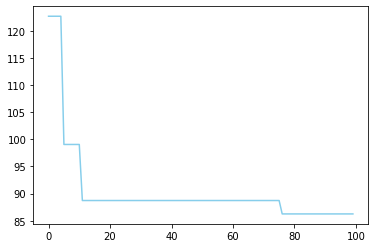

[0, 2, 3, 1, 4]


In [22]:
best, history = genetic_algorithm(cities, adjacency_mat, n_iter=100, verbose=False, print_interval=20, return_history=True)

plt.plot(range(len(history)), history, color="skyblue")
plt.show()
print(best)

In [23]:
from IPython.display import Markdown as md
md(f"Setelah sekitar 10~80 iterasi, sepertinya algoritma telah konvergen ke minimum, nilainya tetap di nilai { min(history) }. Lalu hasilnya optimal rute dengan urutan { best }")

Setelah sekitar 20~30 iterasi, sepertinya algoritma telah konvergen ke minimum, nilainya tetap di nilai 86.25. Lalu hasilnya optimal rute dengan urutan [0, 2, 3, 1, 4]

# Penerapan TSP dengan _random_ 10 kota dan _random_ jarak antar 10 kota


Buat fungsi untuk generate kordinat kota secara random, dengan range random 1-50 (n_cities * factor) untuk menghasilkan batas / _thresold_ 50

In [24]:
def generate_cities(n_cities, factor=5):
    return np.random.rand(n_cities, 2) * n_cities * factor

_generate_cities()_ : generate _n_cities_ dengan random kordinat kota dalam bentuk array numpy. Sekarang, kita membutuhkan beberapa fungsi yang akan membuat matriks jarak antar kota berdasarkan kordinat kota.

In [25]:
def make_mat(coordinates):
    res = [
        [get_distance(city1, city2) for city2 in coordinates]
        for city1 in coordinates
    ]
    return np.asarray(res)

def get_distance(city1, city2):
    return np.sqrt((cities[0] - city2[0])**2 + (city1[1] - city2[1])**2)

lakukan pemeriksaan terhadap fungsi dengan memanggil fungsi _make_mat()_ sehingga memastikan bahwa _generate_cities()_ memang membuat koordinat kota seperti yang diharapkan. Maka akan kita coba mengirimkan kordinat dummy

In [26]:
test_coords = [[0, 0], [0,1], [1,1], [1,0]]
make_mat(test_coords)

array([[0.        , 1.        , 1.41421356, 1.        ],
       [1.        , 0.        , 1.        , 1.41421356],
       [1.        , 0.        , 1.        , 1.41421356],
       [0.        , 1.        , 1.41421356, 1.        ]])

Generate random 10 kota dan kembalikan dalam bentuk jarak antar kota dari 10 kota

In [27]:
generate_cities(10)

array([[35.96719427, 22.28103163],
       [37.60879218, 32.39192667],
       [35.75573249, 48.32691281],
       [45.1919997 ,  4.63639606],
       [30.19485974, 31.16053768],
       [11.02849367, 42.88035683],
       [49.86215081, 19.02268546],
       [26.70386017, 22.0355708 ],
       [44.12810725, 44.94091924],
       [43.08240805, 41.07369208]])

# Percobaan Menemukan Jalur Optimal
Pada tahp ini, fungsi generate random kordinat kota sudah berhasil dilakukan, selanjutnya kita menggunakan algoritma genetika untuk menemukan jalur optimal menggunakan fungsi _genetic_algorithm()_ dengan parameter yang disesuaikan

Generation 0: 252.379593517968
Generation 1: 245.9306846095725
Generation 2: 245.9306846095725
Generation 3: 245.9306846095725
Generation 4: 245.9306846095725
Generation 5: 245.9306846095725
Generation 6: 242.68696706723202
Generation 7: 242.68696706723202
Generation 8: 242.68696706723202
Generation 9: 242.68696706723202
Generation 10: 242.68696706723202
Generation 11: 242.68696706723202
Generation 12: 242.68696706723202
Generation 13: 242.68696706723202
Generation 14: 238.67234490716538
Generation 15: 238.67234490716538
Generation 16: 238.67234490716538
Generation 17: 238.67234490716538
Generation 18: 238.67234490716538
Generation 19: 238.67234490716538
Generation 20: 238.67234490716538
Generation 21: 238.67234490716538
Generation 22: 238.67234490716538
Generation 23: 238.67234490716538
Generation 24: 238.67234490716538
Generation 25: 238.67234490716538
Generation 26: 238.67234490716538
Generation 27: 238.67234490716538
Generation 28: 238.67234490716538
Generation 29: 228.610120189044

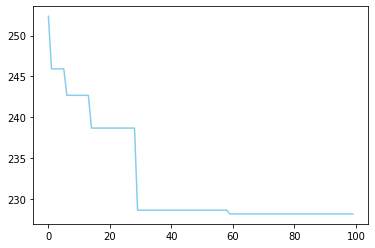

[5, 6, 9, 0, 1, 3, 8, 4, 2, 7]


In [28]:
cities = range(10) # masukan jumlah kota disini, minimal 10 kota
city_coordinates = generate_cities(len(cities))
adjacency_mat = make_mat(city_coordinates)
best, history = genetic_algorithm(
    cities, adjacency_mat, n_population=20, n_iter=100, verbose=True, return_history=True
) # sesuaikan jumlah pupulasi, jumlah iterasi / generasi (jika kurang optimal), dan interval print data setiap 5 generasi
plt.plot(range(len(history)), history, color="skyblue")
plt.show() # tampilkan plot histogram dari peforma optimal setiap iterasi generasi
print(best) # tampilkan jalur terbaik perjalanan yang dapat dilakukan

Menampilkan path / jalur optimal yang dapat di lalui dalam bentuk histogram

In [29]:
def print_path(best, city_coordinates):
    points = city_coordinates[best]
    x, y = zip(*points)
    plt.plot(x,y, color="skyblue", marker="o")

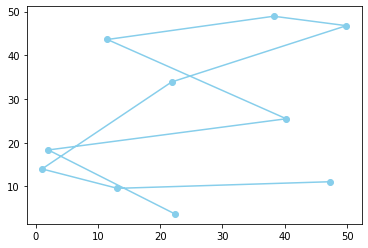

In [30]:
print_path(best, city_coordinates)

# Kesimpulan

In [31]:
print(f"Kordinat dari {len(cities)} kota : \n {city_coordinates} \n Dengan jarak antar kota : \n {adjacency_mat} \n Memiliki nilai jarak optimal : {min(history)} dengan jalur / path : {best}")

Kordinat dari 10 kota : 
 [[21.84043371 33.88824315]
 [49.89615201 46.77347039]
 [ 2.05542267 18.33154509]
 [38.22601052 48.93381834]
 [40.24138581 25.47338063]
 [47.29267582 11.06118984]
 [13.13936488  9.55178434]
 [22.36623869  3.69658719]
 [11.52882724 43.61276143]
 [ 1.04631759 13.98995654]] 
 Dengan jarak antar kota : 
 [[21.84043371 51.53304829 15.69189654 41.08037504 41.11178715 52.51353682
  27.6569365  37.57372383 15.08244388 19.92577704]
 [25.35810769 49.89615201 28.51609857 38.28700803 45.5309011  59.26182724
  39.47273517 48.53726918 11.95424354 32.80020672]
 [26.8144625  57.43317073  2.05542267 48.96659074 40.87022078 47.84825234
  15.80275635 26.72883509 27.78585535  4.46588979]
 [26.52119675 49.94289828 30.67122251 38.22601052 46.58069631 60.58822637
  41.51611146 50.46440047 12.69753929 34.95952313]
 [23.40543645 54.25237146  7.43172775 44.85108714 40.24138581 49.43994771
  20.64316201 31.21662002 21.49304523 11.53099343]
 [31.59238685 61.35953851  7.55531784 53.8104438